manually install torch with cuda:
```terminal
pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
```

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.amp import autocast, GradScaler
import torch.nn.functional as F
import copy
import numpy as np
import optuna
import time
import itertools
import pandas as pd

import optuna

c:\Users\Jax\Coding\Optimierungsverfahren\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### PyTorch with CUDA

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
print("Using device:", device)

Using device: cuda:0


### Get CIFAR10 data

In [3]:
TRAINING_SIZE = 49000 # full data
# TRAINING_SIZE = 5000    # develop data

VALIDATION_SIZE = 1000
BATCH_SIZE = 512
NUM_WORKERS = 12

iters_per_epoch = np.ceil(TRAINING_SIZE / BATCH_SIZE)

RANDOM_SEED = 0
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [4]:
transform_train = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_val_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

cifar10_train = dset.CIFAR10('datasets', train=True, download=True, transform=transform_train)
# cifar10_val = dset.CIFAR10('datasets', train=True, download=True, transform=transform_val_test)
cifar10_test = dset.CIFAR10('datasets', train=False, download=True, transform=transform_val_test)

indices = np.arange(len(cifar10_train))
np.random.shuffle(indices)
train_idx = indices[:TRAINING_SIZE]
val_idx = indices[TRAINING_SIZE:TRAINING_SIZE + VALIDATION_SIZE]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

loader_train = DataLoader(
    cifar10_train,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True
)

loader_val = DataLoader(
    cifar10_train,
    batch_size=BATCH_SIZE,
    sampler=val_sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True
)

print(f"Train batches: {len(loader_train)}, Val batches: {len(loader_val)}")
print(f"Results in {iters_per_epoch} iterations per epoch.")

Train batches: 96, Val batches: 2
Results in 96.0 iterations per epoch.


### Model and Hyperparameter Training

In [5]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    num_epochs=10,
    criterion=None,
    device=None,
    print_every=20,
    patience=3,
    accumulation_steps=1,
    scheduler=None
):
    """
    Optimized training function with AMP, early stopping, gradient accumulation, 
    best model saving, and optional scheduler.
    """
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    criterion = criterion or F.cross_entropy
    optimizer = optimizer
    scaler = GradScaler()

    best_val_acc = -float('inf')
    best_model = None
    epochs_no_improve = 0

    train_accs, val_accs, lrs, epoch_times = [], [], [], []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad() if accumulation_steps == 1 else None

            with autocast("cuda"):
                outputs = model(x)
                loss = criterion(outputs, y) / accumulation_steps  # scale loss for accumulation

            scaler.scale(loss).backward()

            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            running_loss += loss.item() * accumulation_steps
            if (i + 1) % print_every == 0:
                print(f"Epoch {epoch+1}, Iter {i+1}, Avg Loss: {running_loss/print_every:.4f}")
                running_loss = 0.0

        # Step scheduler at epoch end
        if scheduler is not None:
            scheduler.step()
            lrs.append(scheduler.get_last_lr()[0])

        # Validation check
        val_acc = get_accuracy(val_loader, model, f"Validation Epoch {epoch+1}", device)
        val_accs.append(val_acc)
        
        train_acc = get_accuracy(train_loader, model, f"Training Epoch {epoch+1}", device=device)
        train_accs.append(train_acc)

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = copy.deepcopy(model)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    total_time = time.time() - start_time

    return {
        "model": best_model if best_model else model,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "lrs": lrs,
        "epoch_times": epoch_times,
        "total_time": total_time
    }


def get_accuracy(loader, model, name="Validation", device=device, debug=True):
    """
    Compute accuracy of the model on a given DataLoader.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            with autocast("cuda"):
                scores = model(x)
            preds = scores.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = correct / total
    if debug:
        print(f"{name} Accuracy: {100*acc:.2f}%")
    return acc

In [6]:
def hyperparam_training(learn_rate, epochs):

    ch1 = 16
    ch2 = 64
    ch3 = 32
    model = nn.Sequential(
        nn.Conv2d(3, ch1, 5, padding=2),
        nn.BatchNorm2d(ch1),
        nn.ReLU(),

        nn.Conv2d(ch1, ch2, 3, padding=1),
        nn.BatchNorm2d(ch2),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(ch2, ch3, 3, padding=1),
        nn.BatchNorm2d(ch3),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Flatten(),
        nn.Linear(ch3 * 8 * 8, 128),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(128, 10)
    ).to(device)

    weight_decay = 2.075612963823467e-06
    optimizer = torch.optim.AdamW(model.parameters(), lr=learn_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    training_result = train_model(
        model=model,
        train_loader=loader_train,
        val_loader=loader_val,
        num_epochs=epochs,
        device=device,
        print_every=len(loader_train) // 4,
        patience=2,
        optimizer=optimizer,
        scheduler=scheduler,
    )
    trained_model = training_result["model"]
    
    val_acc = get_accuracy(loader_val, trained_model, device=device, debug=False)

    return {
        "lr": learn_rate,
        "epochs": epochs,
        "val_acc": val_acc,
        "train_accs": training_result["train_accs"],
        "val_accs": training_result["val_accs"],
        "runtime": training_result["total_time"],
    }

## Search Algorithms

In [7]:
NUM_TRIALS = 25
GRID_NUM = np.sqrt(NUM_TRIALS).astype(int)
LR_MIN = 1e-6
LR_MAX = 1e-2
EPOCHS_MIN = 5
EPOCHS_MAX = 25

print(f"{NUM_TRIALS} trials will be run, {GRID_NUM} values per grid dimension.")

25 trials will be run, 5 values per grid dimension.


In [8]:
def run_hidden_results():
    HIDDEN_TRIALS = 800
    HIDDEN_GRID_NUM = np.sqrt(HIDDEN_TRIALS).astype(int)

    lr_values = np.logspace(np.log10(LR_MIN), np.log10(LR_MAX), HIDDEN_GRID_NUM)
    epochs_values = np.linspace(EPOCHS_MIN, EPOCHS_MAX, HIDDEN_GRID_NUM, dtype=int)

    results = []
    trial = 1
    for lr, ep in itertools.product(lr_values, epochs_values):
        print(f"\n[Hidden {trial}/{HIDDEN_TRIALS}] lr={lr:.3e}, epochs={ep}")
        res = hyperparam_training(lr, ep)
        res["trial"] = trial
        res["method"] = "Hidden Search"
        results.append(res)
        trial += 1

    return pd.DataFrame(results)

In [ ]:
def run_grid_search():
    lr_values = np.logspace(np.log10(LR_MIN), np.log10(LR_MAX), GRID_NUM)
    epochs_values = np.linspace(EPOCHS_MIN, EPOCHS_MAX, GRID_NUM, dtype=int)

    results = []
    trial = 1
    for lr, ep in itertools.product(lr_values, epochs_values):
        print(f"\n[Grid {trial}/{NUM_TRIALS}] lr={lr:.3e}, epochs={ep}")
        res = hyperparam_training(lr, ep)
        res["trial"] = trial
        res["method"] = "Grid Search"
        results.append(res)
        trial += 1

    return pd.DataFrame(results)

In [44]:
def run_random_search():
    lr_values = 10 ** np.random.uniform(np.log10(LR_MIN), np.log10(LR_MAX), NUM_TRIALS)
    epochs_values = np.random.randint(EPOCHS_MIN, EPOCHS_MAX+1, NUM_TRIALS)

    results = []
    trial = 1
    for lr, ep in zip(lr_values, epochs_values):
        print(f"\n[Random {trial}/{NUM_TRIALS}] lr={lr:.3e}, epochs={ep}")
        res = hyperparam_training(lr, ep)
        res["trial"] = trial
        res["method"] = "Random Search"
        results.append(res)
        trial += 1
        
    return pd.DataFrame(results)

In [ ]:
def objective(trial):
    lr = trial.suggest_float("learn_rate", LR_MIN, LR_MAX, log=True)
    epochs = trial.suggest_int("epochs", EPOCHS_MIN, EPOCHS_MAX)

    results = hyperparam_training(lr, epochs)
    return results["val_acc"]

def run_bayesian_search():
    study_name = "bayesian_optimization"
    storage_name = f"sqlite:///{study_name}.db"

    # Reset study
    summaries = optuna.study.get_all_study_summaries(storage=storage_name)
    if study_name in [s.study_name for s in summaries]:
        optuna.delete_study(study_name=study_name, storage=storage_name)
        print(f"Deleted existing study: {study_name}")

    study = optuna.create_study(
        study_name=study_name,
        storage=storage_name,
        direction="maximize",
    )

    study.optimize(objective, n_trials=NUM_TRIALS)

    rows = []
    for t in study.trials:
        row = {
            "trial": t.number + 1,
            "lr": t.params.get("learn_rate", None),
            "epochs": t.params.get("epochs", None),
            "val_acc": t.value,
            "method": "Bayesian Search"
        }
        rows.append(row)

    return pd.DataFrame(rows), study

## Results

In [9]:
df_hidden = run_hidden_results()
df_hidden.to_csv("results/hidden.csv")


[Hidden 1/800] lr=1.000e-06, epochs=5
Epoch 1, Iter 24, Avg Loss: 2.3405
Epoch 1, Iter 48, Avg Loss: 2.3323
Epoch 1, Iter 72, Avg Loss: 2.3224
Epoch 1, Iter 96, Avg Loss: 2.3216
Validation Epoch 1 Accuracy: 11.50%
Training Epoch 1 Accuracy: 10.71%
Epoch 2, Iter 24, Avg Loss: 2.3128
Epoch 2, Iter 48, Avg Loss: 2.3094
Epoch 2, Iter 72, Avg Loss: 2.3088
Epoch 2, Iter 96, Avg Loss: 2.3052
Validation Epoch 2 Accuracy: 12.40%
Training Epoch 2 Accuracy: 12.13%
Epoch 3, Iter 24, Avg Loss: 2.2988
Epoch 3, Iter 48, Avg Loss: 2.2961
Epoch 3, Iter 72, Avg Loss: 2.2937
Epoch 3, Iter 96, Avg Loss: 2.2925
Validation Epoch 3 Accuracy: 14.50%
Training Epoch 3 Accuracy: 13.28%
Epoch 4, Iter 24, Avg Loss: 2.2883
Epoch 4, Iter 48, Avg Loss: 2.2884
Epoch 4, Iter 72, Avg Loss: 2.2855
Epoch 4, Iter 96, Avg Loss: 2.2880
Validation Epoch 4 Accuracy: 13.20%
Training Epoch 4 Accuracy: 13.50%
Epoch 5, Iter 24, Avg Loss: 2.2839
Epoch 5, Iter 48, Avg Loss: 2.2872
Epoch 5, Iter 72, Avg Loss: 2.2847
Epoch 5, Iter 96

In [ ]:
df_grid = run_grid_search()
df_grid.to_csv("results/grid.csv")


[Grid 1/25] lr=1.000e-06, epochs=5
Epoch 1, Iter 24, Avg Loss: 2.3355
Epoch 1, Iter 48, Avg Loss: 2.3237
Epoch 1, Iter 72, Avg Loss: 2.3200
Epoch 1, Iter 96, Avg Loss: 2.3127
Validation Epoch 1 Accuracy: 9.70%
Training Epoch 1 Accuracy: 10.94%
Epoch 2, Iter 24, Avg Loss: 2.3094
Epoch 2, Iter 48, Avg Loss: 2.3009
Epoch 2, Iter 72, Avg Loss: 2.2994
Epoch 2, Iter 96, Avg Loss: 2.2971
Validation Epoch 2 Accuracy: 11.30%
Training Epoch 2 Accuracy: 12.09%
Epoch 3, Iter 24, Avg Loss: 2.2968
Epoch 3, Iter 48, Avg Loss: 2.2894
Epoch 3, Iter 72, Avg Loss: 2.2870
Epoch 3, Iter 96, Avg Loss: 2.2858
Validation Epoch 3 Accuracy: 12.10%
Training Epoch 3 Accuracy: 13.41%
Epoch 4, Iter 24, Avg Loss: 2.2862
Epoch 4, Iter 48, Avg Loss: 2.2816
Epoch 4, Iter 72, Avg Loss: 2.2804
Epoch 4, Iter 96, Avg Loss: 2.2802
Validation Epoch 4 Accuracy: 15.20%
Training Epoch 4 Accuracy: 14.20%
Epoch 5, Iter 24, Avg Loss: 2.2796
Epoch 5, Iter 48, Avg Loss: 2.2790
Epoch 5, Iter 72, Avg Loss: 2.2767
Epoch 5, Iter 96, Av

In [ ]:
df_random = run_random_search()
df_random.to_csv("results/random.csv")


[Random 1/25] lr=4.157e-04, epochs=11
Epoch 1, Iter 24, Avg Loss: 2.0453
Epoch 1, Iter 48, Avg Loss: 1.7259
Epoch 1, Iter 72, Avg Loss: 1.6049
Epoch 1, Iter 96, Avg Loss: 1.5073
Validation Epoch 1 Accuracy: 44.40%
Training Epoch 1 Accuracy: 48.04%
Epoch 2, Iter 24, Avg Loss: 1.4467
Epoch 2, Iter 48, Avg Loss: 1.4080
Epoch 2, Iter 72, Avg Loss: 1.3766
Epoch 2, Iter 96, Avg Loss: 1.3464
Validation Epoch 2 Accuracy: 53.20%
Training Epoch 2 Accuracy: 54.22%
Epoch 3, Iter 24, Avg Loss: 1.2912
Epoch 3, Iter 48, Avg Loss: 1.2672
Epoch 3, Iter 72, Avg Loss: 1.2609
Epoch 3, Iter 96, Avg Loss: 1.2258
Validation Epoch 3 Accuracy: 56.00%
Training Epoch 3 Accuracy: 56.84%
Epoch 4, Iter 24, Avg Loss: 1.1893
Epoch 4, Iter 48, Avg Loss: 1.1723
Epoch 4, Iter 72, Avg Loss: 1.1691
Epoch 4, Iter 96, Avg Loss: 1.1674
Validation Epoch 4 Accuracy: 61.70%
Training Epoch 4 Accuracy: 60.34%
Epoch 5, Iter 24, Avg Loss: 1.1373
Epoch 5, Iter 48, Avg Loss: 1.1288
Epoch 5, Iter 72, Avg Loss: 1.1079
Epoch 5, Iter 96

In [47]:
df_bayesian, study = run_bayesian_search()
df_bayesian.to_csv("results/bayesian.csv")

[I 2025-12-02 23:17:15,039] A new study created in RDB with name: bayesian_optimization


Deleted existing study: bayesian_optimization
Epoch 1, Iter 24, Avg Loss: 2.3405
Epoch 1, Iter 48, Avg Loss: 2.3322
Epoch 1, Iter 72, Avg Loss: 2.3222
Epoch 1, Iter 96, Avg Loss: 2.3214
Validation Epoch 1 Accuracy: 11.50%
Training Epoch 1 Accuracy: 10.73%
Epoch 2, Iter 24, Avg Loss: 2.3124
Epoch 2, Iter 48, Avg Loss: 2.3086
Epoch 2, Iter 72, Avg Loss: 2.3077
Epoch 2, Iter 96, Avg Loss: 2.3038
Validation Epoch 2 Accuracy: 12.60%
Training Epoch 2 Accuracy: 12.28%
Epoch 3, Iter 24, Avg Loss: 2.2967
Epoch 3, Iter 48, Avg Loss: 2.2931
Epoch 3, Iter 72, Avg Loss: 2.2896
Epoch 3, Iter 96, Avg Loss: 2.2876
Validation Epoch 3 Accuracy: 15.70%
Training Epoch 3 Accuracy: 13.80%
Epoch 4, Iter 24, Avg Loss: 2.2820
Epoch 4, Iter 48, Avg Loss: 2.2805
Epoch 4, Iter 72, Avg Loss: 2.2762
Epoch 4, Iter 96, Avg Loss: 2.2768
Validation Epoch 4 Accuracy: 14.50%
Training Epoch 4 Accuracy: 15.03%
Epoch 5, Iter 24, Avg Loss: 2.2705
Epoch 5, Iter 48, Avg Loss: 2.2725
Epoch 5, Iter 72, Avg Loss: 2.2673
Epoch 5, 

[I 2025-12-02 23:18:51,929] Trial 0 finished with value: 0.18 and parameters: {'learn_rate': 1.0121926938126403e-06, 'epochs': 11}. Best is trial 0 with value: 0.18.


Training Epoch 10 Accuracy: 18.85%
Early stopping triggered after 10 epochs.
Epoch 1, Iter 24, Avg Loss: 2.3057
Epoch 1, Iter 48, Avg Loss: 2.2581
Epoch 1, Iter 72, Avg Loss: 2.2138
Epoch 1, Iter 96, Avg Loss: 2.1712
Validation Epoch 1 Accuracy: 23.80%
Training Epoch 1 Accuracy: 24.96%
Epoch 2, Iter 24, Avg Loss: 2.1221
Epoch 2, Iter 48, Avg Loss: 2.0806
Epoch 2, Iter 72, Avg Loss: 2.0459
Epoch 2, Iter 96, Avg Loss: 2.0168
Validation Epoch 2 Accuracy: 29.70%
Training Epoch 2 Accuracy: 30.90%
Epoch 3, Iter 24, Avg Loss: 1.9845
Epoch 3, Iter 48, Avg Loss: 1.9551
Epoch 3, Iter 72, Avg Loss: 1.9379
Epoch 3, Iter 96, Avg Loss: 1.9234
Validation Epoch 3 Accuracy: 34.60%
Training Epoch 3 Accuracy: 34.57%
Epoch 4, Iter 24, Avg Loss: 1.8963
Epoch 4, Iter 48, Avg Loss: 1.8812
Epoch 4, Iter 72, Avg Loss: 1.8675
Epoch 4, Iter 96, Avg Loss: 1.8478
Validation Epoch 4 Accuracy: 36.00%
Training Epoch 4 Accuracy: 36.95%
Epoch 5, Iter 24, Avg Loss: 1.8419
Epoch 5, Iter 48, Avg Loss: 1.8064
Epoch 5, Iter

[I 2025-12-02 23:19:19,735] Trial 1 finished with value: 0.399 and parameters: {'learn_rate': 1.1763364955451094e-05, 'epochs': 25}. Best is trial 1 with value: 0.399.


Training Epoch 9 Accuracy: 42.39%
Early stopping triggered after 9 epochs.
Epoch 1, Iter 24, Avg Loss: 2.0268
Epoch 1, Iter 48, Avg Loss: 1.7314
Epoch 1, Iter 72, Avg Loss: 1.6131
Epoch 1, Iter 96, Avg Loss: 1.5382
Validation Epoch 1 Accuracy: 45.50%
Training Epoch 1 Accuracy: 46.80%
Epoch 2, Iter 24, Avg Loss: 1.4692
Epoch 2, Iter 48, Avg Loss: 1.4092
Epoch 2, Iter 72, Avg Loss: 1.3288
Epoch 2, Iter 96, Avg Loss: 1.3348
Validation Epoch 2 Accuracy: 49.00%
Training Epoch 2 Accuracy: 51.02%
Epoch 3, Iter 24, Avg Loss: 1.2815
Epoch 3, Iter 48, Avg Loss: 1.2500
Epoch 3, Iter 72, Avg Loss: 1.2422
Epoch 3, Iter 96, Avg Loss: 1.2160
Validation Epoch 3 Accuracy: 57.70%
Training Epoch 3 Accuracy: 56.67%
Epoch 4, Iter 24, Avg Loss: 1.1839
Epoch 4, Iter 48, Avg Loss: 1.1606
Epoch 4, Iter 72, Avg Loss: 1.1295
Epoch 4, Iter 96, Avg Loss: 1.1158
Validation Epoch 4 Accuracy: 57.30%
Training Epoch 4 Accuracy: 59.50%
Epoch 5, Iter 24, Avg Loss: 1.1175
Epoch 5, Iter 48, Avg Loss: 1.0876
Epoch 5, Iter 7

[I 2025-12-02 23:19:57,001] Trial 2 finished with value: 0.687 and parameters: {'learn_rate': 0.0020829768668790627, 'epochs': 22}. Best is trial 2 with value: 0.687.


Training Epoch 12 Accuracy: 69.32%
Early stopping triggered after 12 epochs.
Epoch 1, Iter 24, Avg Loss: 2.1189
Epoch 1, Iter 48, Avg Loss: 1.7442
Epoch 1, Iter 72, Avg Loss: 1.6009
Epoch 1, Iter 96, Avg Loss: 1.5437
Validation Epoch 1 Accuracy: 44.40%
Training Epoch 1 Accuracy: 44.54%
Epoch 2, Iter 24, Avg Loss: 1.4712
Epoch 2, Iter 48, Avg Loss: 1.4373
Epoch 2, Iter 72, Avg Loss: 1.3758
Epoch 2, Iter 96, Avg Loss: 1.3298
Validation Epoch 2 Accuracy: 54.00%
Training Epoch 2 Accuracy: 52.89%
Epoch 3, Iter 24, Avg Loss: 1.2903
Epoch 3, Iter 48, Avg Loss: 1.2456
Epoch 3, Iter 72, Avg Loss: 1.2184
Epoch 3, Iter 96, Avg Loss: 1.1926
Validation Epoch 3 Accuracy: 60.30%
Training Epoch 3 Accuracy: 59.37%
Epoch 4, Iter 24, Avg Loss: 1.1558
Epoch 4, Iter 48, Avg Loss: 1.1427
Epoch 4, Iter 72, Avg Loss: 1.1295
Epoch 4, Iter 96, Avg Loss: 1.1423
Validation Epoch 4 Accuracy: 56.90%
Training Epoch 4 Accuracy: 57.61%
Epoch 5, Iter 24, Avg Loss: 1.0874
Epoch 5, Iter 48, Avg Loss: 1.0759
Epoch 5, Iter

[I 2025-12-02 23:20:18,702] Trial 3 finished with value: 0.662 and parameters: {'learn_rate': 0.0017241691147344296, 'epochs': 7}. Best is trial 2 with value: 0.687.


Training Epoch 7 Accuracy: 67.32%
Epoch 1, Iter 24, Avg Loss: 3.1304
Epoch 1, Iter 48, Avg Loss: 2.1042
Epoch 1, Iter 72, Avg Loss: 1.9912
Epoch 1, Iter 96, Avg Loss: 1.9259
Validation Epoch 1 Accuracy: 31.40%
Training Epoch 1 Accuracy: 32.73%
Epoch 2, Iter 24, Avg Loss: 1.8575
Epoch 2, Iter 48, Avg Loss: 1.7917
Epoch 2, Iter 72, Avg Loss: 1.7522
Epoch 2, Iter 96, Avg Loss: 1.7469
Validation Epoch 2 Accuracy: 38.60%
Training Epoch 2 Accuracy: 39.75%
Epoch 3, Iter 24, Avg Loss: 1.7159
Epoch 3, Iter 48, Avg Loss: 1.7176
Epoch 3, Iter 72, Avg Loss: 1.6958
Epoch 3, Iter 96, Avg Loss: 1.6779
Validation Epoch 3 Accuracy: 41.60%
Training Epoch 3 Accuracy: 40.97%
Epoch 4, Iter 24, Avg Loss: 1.6858
Epoch 4, Iter 48, Avg Loss: 1.6193
Epoch 4, Iter 72, Avg Loss: 1.6247
Epoch 4, Iter 96, Avg Loss: 1.6174
Validation Epoch 4 Accuracy: 43.70%
Training Epoch 4 Accuracy: 44.35%
Epoch 5, Iter 24, Avg Loss: 1.5971
Epoch 5, Iter 48, Avg Loss: 1.6052
Epoch 5, Iter 72, Avg Loss: 1.5799
Epoch 5, Iter 96, Avg

[I 2025-12-02 23:21:11,283] Trial 4 finished with value: 0.624 and parameters: {'learn_rate': 0.007887888212968435, 'epochs': 17}. Best is trial 2 with value: 0.687.


Training Epoch 17 Accuracy: 65.23%
Epoch 1, Iter 24, Avg Loss: 2.2804
Epoch 1, Iter 48, Avg Loss: 2.2209
Epoch 1, Iter 72, Avg Loss: 2.1677
Epoch 1, Iter 96, Avg Loss: 2.1193
Validation Epoch 1 Accuracy: 28.60%
Training Epoch 1 Accuracy: 29.31%
Epoch 2, Iter 24, Avg Loss: 2.0586
Epoch 2, Iter 48, Avg Loss: 2.0181
Epoch 2, Iter 72, Avg Loss: 1.9763
Epoch 2, Iter 96, Avg Loss: 1.9346
Validation Epoch 2 Accuracy: 33.60%
Training Epoch 2 Accuracy: 34.13%
Epoch 3, Iter 24, Avg Loss: 1.9120
Epoch 3, Iter 48, Avg Loss: 1.8735
Epoch 3, Iter 72, Avg Loss: 1.8520
Epoch 3, Iter 96, Avg Loss: 1.8505
Validation Epoch 3 Accuracy: 35.50%
Training Epoch 3 Accuracy: 36.74%
Epoch 4, Iter 24, Avg Loss: 1.8297
Epoch 4, Iter 48, Avg Loss: 1.7985
Epoch 4, Iter 72, Avg Loss: 1.7963
Epoch 4, Iter 96, Avg Loss: 1.7893
Validation Epoch 4 Accuracy: 37.20%
Training Epoch 4 Accuracy: 39.07%
Epoch 5, Iter 24, Avg Loss: 1.7657
Epoch 5, Iter 48, Avg Loss: 1.7465
Epoch 5, Iter 72, Avg Loss: 1.7361
Epoch 5, Iter 96, Av

[I 2025-12-02 23:21:35,971] Trial 5 finished with value: 0.392 and parameters: {'learn_rate': 1.541288968874052e-05, 'epochs': 15}. Best is trial 2 with value: 0.687.


Training Epoch 8 Accuracy: 43.60%
Early stopping triggered after 8 epochs.
Epoch 1, Iter 24, Avg Loss: 2.3220
Epoch 1, Iter 48, Avg Loss: 1.8298
Epoch 1, Iter 72, Avg Loss: 1.7033
Epoch 1, Iter 96, Avg Loss: 1.6179
Validation Epoch 1 Accuracy: 41.80%
Training Epoch 1 Accuracy: 43.02%
Epoch 2, Iter 24, Avg Loss: 1.5422
Epoch 2, Iter 48, Avg Loss: 1.5003
Epoch 2, Iter 72, Avg Loss: 1.4550
Epoch 2, Iter 96, Avg Loss: 1.4145
Validation Epoch 2 Accuracy: 48.40%
Training Epoch 2 Accuracy: 50.19%
Epoch 3, Iter 24, Avg Loss: 1.3584
Epoch 3, Iter 48, Avg Loss: 1.3206
Epoch 3, Iter 72, Avg Loss: 1.2908
Epoch 3, Iter 96, Avg Loss: 1.2998
Validation Epoch 3 Accuracy: 55.00%
Training Epoch 3 Accuracy: 54.89%
Epoch 4, Iter 24, Avg Loss: 1.2599
Epoch 4, Iter 48, Avg Loss: 1.2142
Epoch 4, Iter 72, Avg Loss: 1.2123
Epoch 4, Iter 96, Avg Loss: 1.2002
Validation Epoch 4 Accuracy: 61.40%
Training Epoch 4 Accuracy: 60.98%
Epoch 5, Iter 24, Avg Loss: 1.1813
Epoch 5, Iter 48, Avg Loss: 1.1753
Epoch 5, Iter 7

[I 2025-12-02 23:22:09,187] Trial 6 finished with value: 0.66 and parameters: {'learn_rate': 0.0019709497362647016, 'epochs': 22}. Best is trial 2 with value: 0.687.


Training Epoch 10 Accuracy: 62.14%
Early stopping triggered after 10 epochs.
Epoch 1, Iter 24, Avg Loss: 2.3295
Epoch 1, Iter 48, Avg Loss: 2.3088
Epoch 1, Iter 72, Avg Loss: 2.2864
Epoch 1, Iter 96, Avg Loss: 2.2705
Validation Epoch 1 Accuracy: 14.90%
Training Epoch 1 Accuracy: 14.97%
Epoch 2, Iter 24, Avg Loss: 2.2490
Epoch 2, Iter 48, Avg Loss: 2.2363
Epoch 2, Iter 72, Avg Loss: 2.2160
Epoch 2, Iter 96, Avg Loss: 2.2053
Validation Epoch 2 Accuracy: 23.90%
Training Epoch 2 Accuracy: 23.44%
Epoch 3, Iter 24, Avg Loss: 2.1849
Epoch 3, Iter 48, Avg Loss: 2.1670
Epoch 3, Iter 72, Avg Loss: 2.1520
Epoch 3, Iter 96, Avg Loss: 2.1381
Validation Epoch 3 Accuracy: 27.10%
Training Epoch 3 Accuracy: 27.35%
Epoch 4, Iter 24, Avg Loss: 2.1191
Epoch 4, Iter 48, Avg Loss: 2.1114
Epoch 4, Iter 72, Avg Loss: 2.0963
Epoch 4, Iter 96, Avg Loss: 2.0895
Validation Epoch 4 Accuracy: 29.30%
Training Epoch 4 Accuracy: 29.44%
Epoch 5, Iter 24, Avg Loss: 2.0681
Epoch 5, Iter 48, Avg Loss: 2.0621
Epoch 5, Iter

[I 2025-12-02 23:22:39,412] Trial 7 finished with value: 0.322 and parameters: {'learn_rate': 4.8527237350997885e-06, 'epochs': 9}. Best is trial 2 with value: 0.687.


Training Epoch 9 Accuracy: 32.19%
Epoch 1, Iter 24, Avg Loss: 2.3453
Epoch 1, Iter 48, Avg Loss: 2.3387
Epoch 1, Iter 72, Avg Loss: 2.3277
Epoch 1, Iter 96, Avg Loss: 2.3319
Validation Epoch 1 Accuracy: 11.50%
Training Epoch 1 Accuracy: 11.19%
Epoch 2, Iter 24, Avg Loss: 2.3207
Epoch 2, Iter 48, Avg Loss: 2.3190
Epoch 2, Iter 72, Avg Loss: 2.3101
Epoch 2, Iter 96, Avg Loss: 2.3062
Validation Epoch 2 Accuracy: 11.90%
Training Epoch 2 Accuracy: 12.64%
Epoch 3, Iter 24, Avg Loss: 2.3015
Epoch 3, Iter 48, Avg Loss: 2.3005
Epoch 3, Iter 72, Avg Loss: 2.2995
Epoch 3, Iter 96, Avg Loss: 2.2937
Validation Epoch 3 Accuracy: 13.90%
Training Epoch 3 Accuracy: 14.30%
Epoch 4, Iter 24, Avg Loss: 2.2870
Epoch 4, Iter 48, Avg Loss: 2.2846
Epoch 4, Iter 72, Avg Loss: 2.2803
Epoch 4, Iter 96, Avg Loss: 2.2800
Validation Epoch 4 Accuracy: 15.70%
Training Epoch 4 Accuracy: 16.09%
Epoch 5, Iter 24, Avg Loss: 2.2759
Epoch 5, Iter 48, Avg Loss: 2.2744
Epoch 5, Iter 72, Avg Loss: 2.2706
Epoch 5, Iter 96, Avg

[I 2025-12-02 23:23:06,472] Trial 8 finished with value: 0.196 and parameters: {'learn_rate': 1.0200397209186172e-06, 'epochs': 18}. Best is trial 2 with value: 0.687.


Training Epoch 9 Accuracy: 21.90%
Early stopping triggered after 9 epochs.
Epoch 1, Iter 24, Avg Loss: 2.3077
Epoch 1, Iter 48, Avg Loss: 2.2610
Epoch 1, Iter 72, Avg Loss: 2.2214
Epoch 1, Iter 96, Avg Loss: 2.1791
Validation Epoch 1 Accuracy: 26.50%
Training Epoch 1 Accuracy: 25.09%
Epoch 2, Iter 24, Avg Loss: 2.1338
Epoch 2, Iter 48, Avg Loss: 2.1045
Epoch 2, Iter 72, Avg Loss: 2.0647
Epoch 2, Iter 96, Avg Loss: 2.0354
Validation Epoch 2 Accuracy: 29.10%
Training Epoch 2 Accuracy: 29.98%
Epoch 3, Iter 24, Avg Loss: 2.0102
Epoch 3, Iter 48, Avg Loss: 1.9837
Epoch 3, Iter 72, Avg Loss: 1.9749
Epoch 3, Iter 96, Avg Loss: 1.9557
Validation Epoch 3 Accuracy: 32.30%
Training Epoch 3 Accuracy: 33.42%
Epoch 4, Iter 24, Avg Loss: 1.9338
Epoch 4, Iter 48, Avg Loss: 1.9159
Epoch 4, Iter 72, Avg Loss: 1.9072
Epoch 4, Iter 96, Avg Loss: 1.8782
Validation Epoch 4 Accuracy: 33.30%
Training Epoch 4 Accuracy: 35.75%
Epoch 5, Iter 24, Avg Loss: 1.8741
Epoch 5, Iter 48, Avg Loss: 1.8534
Epoch 5, Iter 7

[I 2025-12-02 23:23:33,600] Trial 9 finished with value: 0.374 and parameters: {'learn_rate': 1.3315473138918703e-05, 'epochs': 11}. Best is trial 2 with value: 0.687.


Training Epoch 9 Accuracy: 40.46%
Early stopping triggered after 9 epochs.
Epoch 1, Iter 24, Avg Loss: 2.1304
Epoch 1, Iter 48, Avg Loss: 1.8455
Epoch 1, Iter 72, Avg Loss: 1.6997
Epoch 1, Iter 96, Avg Loss: 1.6185
Validation Epoch 1 Accuracy: 42.90%
Training Epoch 1 Accuracy: 44.06%
Epoch 2, Iter 24, Avg Loss: 1.5429
Epoch 2, Iter 48, Avg Loss: 1.5066
Epoch 2, Iter 72, Avg Loss: 1.4843
Epoch 2, Iter 96, Avg Loss: 1.4595
Validation Epoch 2 Accuracy: 47.80%
Training Epoch 2 Accuracy: 49.38%
Epoch 3, Iter 24, Avg Loss: 1.4222
Epoch 3, Iter 48, Avg Loss: 1.3934
Epoch 3, Iter 72, Avg Loss: 1.3694
Epoch 3, Iter 96, Avg Loss: 1.3519
Validation Epoch 3 Accuracy: 49.10%
Training Epoch 3 Accuracy: 53.63%
Epoch 4, Iter 24, Avg Loss: 1.3386
Epoch 4, Iter 48, Avg Loss: 1.3150
Epoch 4, Iter 72, Avg Loss: 1.3046
Epoch 4, Iter 96, Avg Loss: 1.2815
Validation Epoch 4 Accuracy: 53.10%
Training Epoch 4 Accuracy: 54.30%
Epoch 5, Iter 24, Avg Loss: 1.2654
Epoch 5, Iter 48, Avg Loss: 1.2631
Epoch 5, Iter 7

[I 2025-12-02 23:23:59,370] Trial 10 finished with value: 0.603 and parameters: {'learn_rate': 0.00019253157014098777, 'epochs': 21}. Best is trial 2 with value: 0.687.


Training Epoch 8 Accuracy: 60.87%
Early stopping triggered after 8 epochs.
Epoch 1, Iter 24, Avg Loss: 2.0281
Epoch 1, Iter 48, Avg Loss: 1.7236
Epoch 1, Iter 72, Avg Loss: 1.5887
Epoch 1, Iter 96, Avg Loss: 1.5163
Validation Epoch 1 Accuracy: 47.50%
Training Epoch 1 Accuracy: 47.48%
Epoch 2, Iter 24, Avg Loss: 1.4563
Epoch 2, Iter 48, Avg Loss: 1.3952
Epoch 2, Iter 72, Avg Loss: 1.3659
Epoch 2, Iter 96, Avg Loss: 1.3053
Validation Epoch 2 Accuracy: 54.10%
Training Epoch 2 Accuracy: 53.70%
Epoch 3, Iter 24, Avg Loss: 1.2665
Epoch 3, Iter 48, Avg Loss: 1.2441
Epoch 3, Iter 72, Avg Loss: 1.2358
Epoch 3, Iter 96, Avg Loss: 1.2036
Validation Epoch 3 Accuracy: 59.90%
Training Epoch 3 Accuracy: 59.18%
Epoch 4, Iter 24, Avg Loss: 1.1809
Epoch 4, Iter 48, Avg Loss: 1.1577
Epoch 4, Iter 72, Avg Loss: 1.1506
Epoch 4, Iter 96, Avg Loss: 1.1401
Validation Epoch 4 Accuracy: 61.70%
Training Epoch 4 Accuracy: 62.03%
Epoch 5, Iter 24, Avg Loss: 1.1282
Epoch 5, Iter 48, Avg Loss: 1.1171
Epoch 5, Iter 7

[I 2025-12-02 23:24:14,995] Trial 11 finished with value: 0.622 and parameters: {'learn_rate': 0.0008409728949705777, 'epochs': 5}. Best is trial 2 with value: 0.687.


Training Epoch 5 Accuracy: 62.62%
Epoch 1, Iter 24, Avg Loss: 2.0205
Epoch 1, Iter 48, Avg Loss: 1.7383
Epoch 1, Iter 72, Avg Loss: 1.5960
Epoch 1, Iter 96, Avg Loss: 1.5316
Validation Epoch 1 Accuracy: 48.80%
Training Epoch 1 Accuracy: 46.49%
Epoch 2, Iter 24, Avg Loss: 1.4665
Epoch 2, Iter 48, Avg Loss: 1.4044
Epoch 2, Iter 72, Avg Loss: 1.3774
Epoch 2, Iter 96, Avg Loss: 1.3370
Validation Epoch 2 Accuracy: 51.00%
Training Epoch 2 Accuracy: 54.29%
Epoch 3, Iter 24, Avg Loss: 1.3030
Epoch 3, Iter 48, Avg Loss: 1.2802
Epoch 3, Iter 72, Avg Loss: 1.2530
Epoch 3, Iter 96, Avg Loss: 1.2290
Validation Epoch 3 Accuracy: 57.30%
Training Epoch 3 Accuracy: 58.57%
Epoch 4, Iter 24, Avg Loss: 1.2094
Epoch 4, Iter 48, Avg Loss: 1.1901
Epoch 4, Iter 72, Avg Loss: 1.1947
Epoch 4, Iter 96, Avg Loss: 1.1977
Validation Epoch 4 Accuracy: 60.20%
Training Epoch 4 Accuracy: 60.18%
Epoch 5, Iter 24, Avg Loss: 1.1677
Epoch 5, Iter 48, Avg Loss: 1.1471
Epoch 5, Iter 72, Avg Loss: 1.1612
Epoch 5, Iter 96, Avg

[I 2025-12-02 23:24:32,290] Trial 12 finished with value: 0.599 and parameters: {'learn_rate': 0.00040721541536721745, 'epochs': 5}. Best is trial 2 with value: 0.687.


Training Epoch 5 Accuracy: 61.05%
Epoch 1, Iter 24, Avg Loss: 3.1617
Epoch 1, Iter 48, Avg Loss: 2.0600
Epoch 1, Iter 72, Avg Loss: 1.9350
Epoch 1, Iter 96, Avg Loss: 1.8378
Validation Epoch 1 Accuracy: 33.00%
Training Epoch 1 Accuracy: 33.83%
Epoch 2, Iter 24, Avg Loss: 1.7910
Epoch 2, Iter 48, Avg Loss: 1.7538
Epoch 2, Iter 72, Avg Loss: 1.7284
Epoch 2, Iter 96, Avg Loss: 1.6857
Validation Epoch 2 Accuracy: 38.90%
Training Epoch 2 Accuracy: 40.61%
Epoch 3, Iter 24, Avg Loss: 1.6757
Epoch 3, Iter 48, Avg Loss: 1.6447
Epoch 3, Iter 72, Avg Loss: 1.6159
Epoch 3, Iter 96, Avg Loss: 1.5986
Validation Epoch 3 Accuracy: 43.90%
Training Epoch 3 Accuracy: 45.84%
Epoch 4, Iter 24, Avg Loss: 1.5840
Epoch 4, Iter 48, Avg Loss: 1.5620
Epoch 4, Iter 72, Avg Loss: 1.5477
Epoch 4, Iter 96, Avg Loss: 1.5326
Validation Epoch 4 Accuracy: 43.90%
Training Epoch 4 Accuracy: 46.38%
Epoch 5, Iter 24, Avg Loss: 1.5012
Epoch 5, Iter 48, Avg Loss: 1.4890
Epoch 5, Iter 72, Avg Loss: 1.4789
Epoch 5, Iter 96, Avg

[I 2025-12-02 23:25:29,448] Trial 13 finished with value: 0.654 and parameters: {'learn_rate': 0.00681689144108177, 'epochs': 25}. Best is trial 2 with value: 0.687.


Training Epoch 17 Accuracy: 68.37%
Early stopping triggered after 17 epochs.
Epoch 1, Iter 24, Avg Loss: 2.0144
Epoch 1, Iter 48, Avg Loss: 1.7269
Epoch 1, Iter 72, Avg Loss: 1.5887
Epoch 1, Iter 96, Avg Loss: 1.5267
Validation Epoch 1 Accuracy: 45.20%
Training Epoch 1 Accuracy: 45.68%
Epoch 2, Iter 24, Avg Loss: 1.4534
Epoch 2, Iter 48, Avg Loss: 1.4319
Epoch 2, Iter 72, Avg Loss: 1.3677
Epoch 2, Iter 96, Avg Loss: 1.3387
Validation Epoch 2 Accuracy: 53.30%
Training Epoch 2 Accuracy: 53.80%
Epoch 3, Iter 24, Avg Loss: 1.2883
Epoch 3, Iter 48, Avg Loss: 1.2553
Epoch 3, Iter 72, Avg Loss: 1.2468
Epoch 3, Iter 96, Avg Loss: 1.2134
Validation Epoch 3 Accuracy: 56.60%
Training Epoch 3 Accuracy: 56.40%
Epoch 4, Iter 24, Avg Loss: 1.1926
Epoch 4, Iter 48, Avg Loss: 1.1678
Epoch 4, Iter 72, Avg Loss: 1.1526
Epoch 4, Iter 96, Avg Loss: 1.1259
Validation Epoch 4 Accuracy: 61.10%
Training Epoch 4 Accuracy: 59.98%
Epoch 5, Iter 24, Avg Loss: 1.1215
Epoch 5, Iter 48, Avg Loss: 1.1097
Epoch 5, Iter

[I 2025-12-02 23:26:00,572] Trial 14 finished with value: 0.68 and parameters: {'learn_rate': 0.0016120013188531959, 'epochs': 9}. Best is trial 2 with value: 0.687.


Training Epoch 9 Accuracy: 68.55%
Epoch 1, Iter 24, Avg Loss: 2.2033
Epoch 1, Iter 48, Avg Loss: 1.9876
Epoch 1, Iter 72, Avg Loss: 1.8587
Epoch 1, Iter 96, Avg Loss: 1.7723
Validation Epoch 1 Accuracy: 39.10%
Training Epoch 1 Accuracy: 40.40%
Epoch 2, Iter 24, Avg Loss: 1.7039
Epoch 2, Iter 48, Avg Loss: 1.6521
Epoch 2, Iter 72, Avg Loss: 1.6260
Epoch 2, Iter 96, Avg Loss: 1.5827
Validation Epoch 2 Accuracy: 44.70%
Training Epoch 2 Accuracy: 45.12%
Epoch 3, Iter 24, Avg Loss: 1.5709
Epoch 3, Iter 48, Avg Loss: 1.5203
Epoch 3, Iter 72, Avg Loss: 1.5123
Epoch 3, Iter 96, Avg Loss: 1.4843
Validation Epoch 3 Accuracy: 46.10%
Training Epoch 3 Accuracy: 48.93%
Epoch 4, Iter 24, Avg Loss: 1.4737
Epoch 4, Iter 48, Avg Loss: 1.4584
Epoch 4, Iter 72, Avg Loss: 1.4343
Epoch 4, Iter 96, Avg Loss: 1.4341
Validation Epoch 4 Accuracy: 50.10%
Training Epoch 4 Accuracy: 50.98%
Epoch 5, Iter 24, Avg Loss: 1.4159
Epoch 5, Iter 48, Avg Loss: 1.4131
Epoch 5, Iter 72, Avg Loss: 1.4019
Epoch 5, Iter 96, Avg

[I 2025-12-02 23:26:42,560] Trial 15 finished with value: 0.56 and parameters: {'learn_rate': 8.075421628377489e-05, 'epochs': 13}. Best is trial 2 with value: 0.687.


Training Epoch 13 Accuracy: 57.30%
Early stopping triggered after 13 epochs.
Epoch 1, Iter 24, Avg Loss: 2.2424
Epoch 1, Iter 48, Avg Loss: 2.0503
Epoch 1, Iter 72, Avg Loss: 1.9233
Epoch 1, Iter 96, Avg Loss: 1.8409
Validation Epoch 1 Accuracy: 36.10%
Training Epoch 1 Accuracy: 37.51%
Epoch 2, Iter 24, Avg Loss: 1.7768
Epoch 2, Iter 48, Avg Loss: 1.7254
Epoch 2, Iter 72, Avg Loss: 1.6852
Epoch 2, Iter 96, Avg Loss: 1.6463
Validation Epoch 2 Accuracy: 41.30%
Training Epoch 2 Accuracy: 43.25%
Epoch 3, Iter 24, Avg Loss: 1.6055
Epoch 3, Iter 48, Avg Loss: 1.5851
Epoch 3, Iter 72, Avg Loss: 1.5727
Epoch 3, Iter 96, Avg Loss: 1.5434
Validation Epoch 3 Accuracy: 46.40%
Training Epoch 3 Accuracy: 47.16%
Epoch 4, Iter 24, Avg Loss: 1.5243
Epoch 4, Iter 48, Avg Loss: 1.5105
Epoch 4, Iter 72, Avg Loss: 1.4798
Epoch 4, Iter 96, Avg Loss: 1.4573
Validation Epoch 4 Accuracy: 47.30%
Training Epoch 4 Accuracy: 49.40%
Epoch 5, Iter 24, Avg Loss: 1.4481
Epoch 5, Iter 48, Avg Loss: 1.4342
Epoch 5, Iter

[I 2025-12-02 23:27:39,897] Trial 16 finished with value: 0.596 and parameters: {'learn_rate': 7.498244538121167e-05, 'epochs': 21}. Best is trial 2 with value: 0.687.


Training Epoch 18 Accuracy: 60.31%
Early stopping triggered after 18 epochs.
Epoch 1, Iter 24, Avg Loss: 2.2485
Epoch 1, Iter 48, Avg Loss: 1.8749
Epoch 1, Iter 72, Avg Loss: 1.7368
Epoch 1, Iter 96, Avg Loss: 1.6587
Validation Epoch 1 Accuracy: 40.60%
Training Epoch 1 Accuracy: 42.53%
Epoch 2, Iter 24, Avg Loss: 1.6012
Epoch 2, Iter 48, Avg Loss: 1.5434
Epoch 2, Iter 72, Avg Loss: 1.5119
Epoch 2, Iter 96, Avg Loss: 1.4953
Validation Epoch 2 Accuracy: 46.80%
Training Epoch 2 Accuracy: 48.66%
Epoch 3, Iter 24, Avg Loss: 1.4517
Epoch 3, Iter 48, Avg Loss: 1.4253
Epoch 3, Iter 72, Avg Loss: 1.3664
Epoch 3, Iter 96, Avg Loss: 1.3472
Validation Epoch 3 Accuracy: 50.10%
Training Epoch 3 Accuracy: 52.15%
Epoch 4, Iter 24, Avg Loss: 1.2906
Epoch 4, Iter 48, Avg Loss: 1.2787
Epoch 4, Iter 72, Avg Loss: 1.2589
Epoch 4, Iter 96, Avg Loss: 1.2309
Validation Epoch 4 Accuracy: 58.70%
Training Epoch 4 Accuracy: 60.29%
Epoch 5, Iter 24, Avg Loss: 1.2170
Epoch 5, Iter 48, Avg Loss: 1.1774
Epoch 5, Iter

[I 2025-12-02 23:28:08,502] Trial 17 finished with value: 0.652 and parameters: {'learn_rate': 0.002798302419321092, 'epochs': 18}. Best is trial 2 with value: 0.687.


Training Epoch 9 Accuracy: 64.11%
Early stopping triggered after 9 epochs.
Epoch 1, Iter 24, Avg Loss: 1.9855
Epoch 1, Iter 48, Avg Loss: 1.6672
Epoch 1, Iter 72, Avg Loss: 1.5551
Epoch 1, Iter 96, Avg Loss: 1.4782
Validation Epoch 1 Accuracy: 44.00%
Training Epoch 1 Accuracy: 47.91%
Epoch 2, Iter 24, Avg Loss: 1.4434
Epoch 2, Iter 48, Avg Loss: 1.3857
Epoch 2, Iter 72, Avg Loss: 1.3499
Epoch 2, Iter 96, Avg Loss: 1.3060
Validation Epoch 2 Accuracy: 52.40%
Training Epoch 2 Accuracy: 54.53%
Epoch 3, Iter 24, Avg Loss: 1.2739
Epoch 3, Iter 48, Avg Loss: 1.2346
Epoch 3, Iter 72, Avg Loss: 1.2113
Epoch 3, Iter 96, Avg Loss: 1.2049
Validation Epoch 3 Accuracy: 57.30%
Training Epoch 3 Accuracy: 59.59%
Epoch 4, Iter 24, Avg Loss: 1.1756
Epoch 4, Iter 48, Avg Loss: 1.1629
Epoch 4, Iter 72, Avg Loss: 1.1267
Epoch 4, Iter 96, Avg Loss: 1.1128
Validation Epoch 4 Accuracy: 57.50%
Training Epoch 4 Accuracy: 57.01%
Epoch 5, Iter 24, Avg Loss: 1.1090
Epoch 5, Iter 48, Avg Loss: 1.0930
Epoch 5, Iter 7

[I 2025-12-02 23:28:31,824] Trial 18 finished with value: 0.616 and parameters: {'learn_rate': 0.0005814153915757904, 'epochs': 14}. Best is trial 2 with value: 0.687.


Training Epoch 7 Accuracy: 64.45%
Early stopping triggered after 7 epochs.
Epoch 1, Iter 24, Avg Loss: 2.0923
Epoch 1, Iter 48, Avg Loss: 1.8182
Epoch 1, Iter 72, Avg Loss: 1.6821
Epoch 1, Iter 96, Avg Loss: 1.6181
Validation Epoch 1 Accuracy: 42.70%
Training Epoch 1 Accuracy: 44.56%
Epoch 2, Iter 24, Avg Loss: 1.5411
Epoch 2, Iter 48, Avg Loss: 1.5097
Epoch 2, Iter 72, Avg Loss: 1.4702
Epoch 2, Iter 96, Avg Loss: 1.4376
Validation Epoch 2 Accuracy: 50.40%
Training Epoch 2 Accuracy: 51.03%
Epoch 3, Iter 24, Avg Loss: 1.4148
Epoch 3, Iter 48, Avg Loss: 1.3801
Epoch 3, Iter 72, Avg Loss: 1.3605
Epoch 3, Iter 96, Avg Loss: 1.3320
Validation Epoch 3 Accuracy: 51.30%
Training Epoch 3 Accuracy: 54.42%
Epoch 4, Iter 24, Avg Loss: 1.3140
Epoch 4, Iter 48, Avg Loss: 1.2985
Epoch 4, Iter 72, Avg Loss: 1.2731
Epoch 4, Iter 96, Avg Loss: 1.2659
Validation Epoch 4 Accuracy: 54.80%
Training Epoch 4 Accuracy: 56.75%
Epoch 5, Iter 24, Avg Loss: 1.2654
Epoch 5, Iter 48, Avg Loss: 1.2461
Epoch 5, Iter 7

[I 2025-12-02 23:29:01,660] Trial 19 finished with value: 0.581 and parameters: {'learn_rate': 0.0002082614797755819, 'epochs': 9}. Best is trial 2 with value: 0.687.


Training Epoch 9 Accuracy: 60.90%
Epoch 1, Iter 24, Avg Loss: 2.6239
Epoch 1, Iter 48, Avg Loss: 1.9378
Epoch 1, Iter 72, Avg Loss: 1.8178
Epoch 1, Iter 96, Avg Loss: 1.7631
Validation Epoch 1 Accuracy: 38.80%
Training Epoch 1 Accuracy: 39.67%
Epoch 2, Iter 24, Avg Loss: 1.7037
Epoch 2, Iter 48, Avg Loss: 1.6687
Epoch 2, Iter 72, Avg Loss: 1.6201
Epoch 2, Iter 96, Avg Loss: 1.5736
Validation Epoch 2 Accuracy: 46.90%
Training Epoch 2 Accuracy: 46.60%
Epoch 3, Iter 24, Avg Loss: 1.5466
Epoch 3, Iter 48, Avg Loss: 1.5319
Epoch 3, Iter 72, Avg Loss: 1.4950
Epoch 3, Iter 96, Avg Loss: 1.4708
Validation Epoch 3 Accuracy: 46.20%
Training Epoch 3 Accuracy: 47.60%
Epoch 4, Iter 24, Avg Loss: 1.4497
Epoch 4, Iter 48, Avg Loss: 1.4210
Epoch 4, Iter 72, Avg Loss: 1.3824
Epoch 4, Iter 96, Avg Loss: 1.3809
Validation Epoch 4 Accuracy: 52.80%
Training Epoch 4 Accuracy: 52.26%
Epoch 5, Iter 24, Avg Loss: 1.3558
Epoch 5, Iter 48, Avg Loss: 1.3267
Epoch 5, Iter 72, Avg Loss: 1.3124
Epoch 5, Iter 96, Avg

[I 2025-12-02 23:29:44,560] Trial 20 finished with value: 0.673 and parameters: {'learn_rate': 0.0039704772834377785, 'epochs': 16}. Best is trial 2 with value: 0.687.


Training Epoch 13 Accuracy: 67.66%
Early stopping triggered after 13 epochs.
Epoch 1, Iter 24, Avg Loss: 2.4637
Epoch 1, Iter 48, Avg Loss: 1.9710
Epoch 1, Iter 72, Avg Loss: 1.8383
Epoch 1, Iter 96, Avg Loss: 1.7508
Validation Epoch 1 Accuracy: 36.60%
Training Epoch 1 Accuracy: 38.20%
Epoch 2, Iter 24, Avg Loss: 1.6954
Epoch 2, Iter 48, Avg Loss: 1.6322
Epoch 2, Iter 72, Avg Loss: 1.5817
Epoch 2, Iter 96, Avg Loss: 1.5766
Validation Epoch 2 Accuracy: 44.60%
Training Epoch 2 Accuracy: 45.79%
Epoch 3, Iter 24, Avg Loss: 1.5188
Epoch 3, Iter 48, Avg Loss: 1.4803
Epoch 3, Iter 72, Avg Loss: 1.4844
Epoch 3, Iter 96, Avg Loss: 1.4192
Validation Epoch 3 Accuracy: 52.90%
Training Epoch 3 Accuracy: 52.36%
Epoch 4, Iter 24, Avg Loss: 1.3845
Epoch 4, Iter 48, Avg Loss: 1.3644
Epoch 4, Iter 72, Avg Loss: 1.3307
Epoch 4, Iter 96, Avg Loss: 1.3150
Validation Epoch 4 Accuracy: 53.10%
Training Epoch 4 Accuracy: 53.34%
Epoch 5, Iter 24, Avg Loss: 1.2977
Epoch 5, Iter 48, Avg Loss: 1.2624
Epoch 5, Iter

[I 2025-12-02 23:30:24,066] Trial 21 finished with value: 0.665 and parameters: {'learn_rate': 0.003932214894780832, 'epochs': 16}. Best is trial 2 with value: 0.687.


Training Epoch 12 Accuracy: 67.32%
Early stopping triggered after 12 epochs.
Epoch 1, Iter 24, Avg Loss: 1.9773
Epoch 1, Iter 48, Avg Loss: 1.6697
Epoch 1, Iter 72, Avg Loss: 1.5348
Epoch 1, Iter 96, Avg Loss: 1.4985
Validation Epoch 1 Accuracy: 50.10%
Training Epoch 1 Accuracy: 50.11%
Epoch 2, Iter 24, Avg Loss: 1.4410
Epoch 2, Iter 48, Avg Loss: 1.3635
Epoch 2, Iter 72, Avg Loss: 1.3321
Epoch 2, Iter 96, Avg Loss: 1.2898
Validation Epoch 2 Accuracy: 51.20%
Training Epoch 2 Accuracy: 50.93%
Epoch 3, Iter 24, Avg Loss: 1.2423
Epoch 3, Iter 48, Avg Loss: 1.2340
Epoch 3, Iter 72, Avg Loss: 1.1819
Epoch 3, Iter 96, Avg Loss: 1.1884
Validation Epoch 3 Accuracy: 55.40%
Training Epoch 3 Accuracy: 57.31%
Epoch 4, Iter 24, Avg Loss: 1.1547
Epoch 4, Iter 48, Avg Loss: 1.1461
Epoch 4, Iter 72, Avg Loss: 1.1204
Epoch 4, Iter 96, Avg Loss: 1.1011
Validation Epoch 4 Accuracy: 57.90%
Training Epoch 4 Accuracy: 59.23%
Epoch 5, Iter 24, Avg Loss: 1.0857
Epoch 5, Iter 48, Avg Loss: 1.0825
Epoch 5, Iter

[I 2025-12-02 23:31:16,757] Trial 22 finished with value: 0.719 and parameters: {'learn_rate': 0.0011186970833714613, 'epochs': 19}. Best is trial 22 with value: 0.719.


Training Epoch 16 Accuracy: 73.35%
Early stopping triggered after 16 epochs.
Epoch 1, Iter 24, Avg Loss: 1.9565
Epoch 1, Iter 48, Avg Loss: 1.6415
Epoch 1, Iter 72, Avg Loss: 1.5226
Epoch 1, Iter 96, Avg Loss: 1.4467
Validation Epoch 1 Accuracy: 42.70%
Training Epoch 1 Accuracy: 44.04%
Epoch 2, Iter 24, Avg Loss: 1.4094
Epoch 2, Iter 48, Avg Loss: 1.3714
Epoch 2, Iter 72, Avg Loss: 1.3023
Epoch 2, Iter 96, Avg Loss: 1.2972
Validation Epoch 2 Accuracy: 52.50%
Training Epoch 2 Accuracy: 53.16%
Epoch 3, Iter 24, Avg Loss: 1.2422
Epoch 3, Iter 48, Avg Loss: 1.2008
Epoch 3, Iter 72, Avg Loss: 1.1855
Epoch 3, Iter 96, Avg Loss: 1.1708
Validation Epoch 3 Accuracy: 60.30%
Training Epoch 3 Accuracy: 59.39%
Epoch 4, Iter 24, Avg Loss: 1.1556
Epoch 4, Iter 48, Avg Loss: 1.0940
Epoch 4, Iter 72, Avg Loss: 1.1083
Epoch 4, Iter 96, Avg Loss: 1.0993
Validation Epoch 4 Accuracy: 61.20%
Training Epoch 4 Accuracy: 61.53%
Epoch 5, Iter 24, Avg Loss: 1.0894
Epoch 5, Iter 48, Avg Loss: 1.0819
Epoch 5, Iter

[I 2025-12-02 23:32:02,366] Trial 23 finished with value: 0.708 and parameters: {'learn_rate': 0.0009407849140057206, 'epochs': 23}. Best is trial 22 with value: 0.719.


Training Epoch 14 Accuracy: 72.26%
Early stopping triggered after 14 epochs.
Epoch 1, Iter 24, Avg Loss: 2.0830
Epoch 1, Iter 48, Avg Loss: 1.7335
Epoch 1, Iter 72, Avg Loss: 1.5570
Epoch 1, Iter 96, Avg Loss: 1.5093
Validation Epoch 1 Accuracy: 46.90%
Training Epoch 1 Accuracy: 48.14%
Epoch 2, Iter 24, Avg Loss: 1.4556
Epoch 2, Iter 48, Avg Loss: 1.3779
Epoch 2, Iter 72, Avg Loss: 1.3356
Epoch 2, Iter 96, Avg Loss: 1.2953
Validation Epoch 2 Accuracy: 51.80%
Training Epoch 2 Accuracy: 55.22%
Epoch 3, Iter 24, Avg Loss: 1.2393
Epoch 3, Iter 48, Avg Loss: 1.2422
Epoch 3, Iter 72, Avg Loss: 1.2104
Epoch 3, Iter 96, Avg Loss: 1.1727
Validation Epoch 3 Accuracy: 59.60%
Training Epoch 3 Accuracy: 59.31%
Epoch 4, Iter 24, Avg Loss: 1.1639
Epoch 4, Iter 48, Avg Loss: 1.1534
Epoch 4, Iter 72, Avg Loss: 1.1270
Epoch 4, Iter 96, Avg Loss: 1.1163
Validation Epoch 4 Accuracy: 62.40%
Training Epoch 4 Accuracy: 61.99%
Epoch 5, Iter 24, Avg Loss: 1.0960
Epoch 5, Iter 48, Avg Loss: 1.0880
Epoch 5, Iter

[I 2025-12-02 23:32:35,729] Trial 24 finished with value: 0.688 and parameters: {'learn_rate': 0.0009918285113207654, 'epochs': 23}. Best is trial 22 with value: 0.719.


Training Epoch 11 Accuracy: 66.46%
Early stopping triggered after 11 epochs.


## Visualizations

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import os
import itertools

sns.set_theme(context="talk", style="whitegrid")

FIGSIZE = {
    "full": (6.4, 3.6),
    "half": (3.1, 1.8),
    # "tall": (5.0, 4.0),
    # "wide": (7.0, 3.5),
}

plt.rcParams.update({
    # --- Figure layout ---
    "figure.figsize": FIGSIZE["full"],      # 16:9 aspect ratio (full width)
    "figure.dpi": 200,                 
    "savefig.dpi": 300,                

    # --- Font sizes ---
    "font.size": 10,                   # match Beamer base font
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,

    # --- Fonts ---
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Fira Sans"],
    "text.latex.preamble": r"""
        \usepackage{FiraSans}
        \usepackage{sfmath}
        \renewcommand*\familydefault{\sfdefault}
    """,

    # --- Axes and grid ---
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.linestyle": ":",
    "grid.alpha": 0.3,

    # --- Save options ---
    # "savefig.bbox": "tight",
    "savefig.pad_inches": 0.02,
})

In [41]:
def savefig(name, ext="pdf", imag_dir="images", transparent=True, dpi=300):
    """
    Save the current matplotlib figure in a clean, consistent format.

    Parameters
    ----------
    name : str
        Base filename (no extension).
    ext : str, optional
        File extension, e.g. 'pdf', 'png', or 'svg'. Default is 'pdf'.
    transparent : bool, optional
        Use transparent background (useful for LaTeX Beamer overlays). Default is True.
    dpi : int, optional
        Dots per inch for raster formats (e.g., PNG). Default is 300.
    """

    # Ensure output directory exists
    os.makedirs(imag_dir, exist_ok=True)
    
    path = os.path.join(imag_dir, f"{name}.{ext}")
    plt.savefig(path, dpi=dpi, bbox_inches="tight", transparent=transparent)

    plt.close()
    print(f"💾 Saved: {path}")

def plot_contour_scatter(df_scatter, filename, df_hidden):
    """
    df_scatter → DataFrame für ScatterPunkte Suchmethode
    filename   → Name für savefig()
    df_hidden  → vollständiger Hyperparameter-Grid (für Contour)
    """

    # build lr/epoch grid
    lr_vals = np.sort(df_hidden["lr"].unique())
    epoch_vals = np.sort(df_hidden["epochs"].unique())
    df_hidden_unique = df_hidden.drop_duplicates(subset=["epochs", "lr"])

    Z = (
        df_hidden_unique
        .pivot(index="epochs", columns="lr", values="val_acc")
        .reindex(index=epoch_vals, columns=lr_vals)
    )

    X, Y = np.meshgrid(lr_vals, epoch_vals)

    # Number of contour levels = reasonable (not N points!)
    n_levels = 15

    plt.figure(constrained_layout=True)

    # no white contour edges → linewidths=0
    cs = plt.contourf(
        X, Y, Z.values,
        levels=n_levels,
        cmap="viridis",
    )
    plt.xscale("log")
    plt.xlabel("Lernrate")
    plt.ylabel("Epochen")

    # Colorbar formatting
    cbar = plt.colorbar(cs, label="Accuracy")
    cbar.ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

    # Epoch axis integer format
    plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))

    # Search points
    plt.scatter(df_scatter["lr"], df_scatter["epochs"], 
                color="firebrick",
                # edgecolor="black",
                label="Getestete Kombinationen")

    plt.legend()
    savefig(filename)
    plt.show()

In [12]:
df_hidden = pd.read_csv("results/hidden.csv", index_col=0)
df_grid = pd.read_csv("results/grid.csv", index_col=0)
df_random = pd.read_csv("results/random.csv", index_col=0)
df_bayesian = pd.read_csv("results/bayesian.csv", index_col=0)

In [42]:
plot_contour_scatter(df_grid, "contour_grid", df_hidden)
plot_contour_scatter(df_random, "contour_random", df_hidden)
plot_contour_scatter(df_bayesian, "contour_bayesian", df_hidden)

💾 Saved: images\contour_grid.pdf
💾 Saved: images\contour_random.pdf
💾 Saved: images\contour_bayesian.pdf


In [33]:
# Prepare combined dataframe
df_all = pd.concat([df_grid, df_random, df_bayesian], ignore_index=True)

# Compute global max and band
global_max = df_all["val_acc"].max()
LOWER_BOUND = 0.95
lower_band = global_max * LOWER_BOUND
percent = int(np.round((1 - LOWER_BOUND) * 100))
label_top_band = f"$\ge$\,{LOWER_BOUND*100:.0f}\,\% des globalen Maximums"

# Create FacetGrid with columns per method
n_cols = 3
subplot_width = FIGSIZE["full"][0] / n_cols  # Breite pro Subplot
height = FIGSIZE["full"][1]                  # Höhe pro Subplot
aspect = subplot_width / height + 0.4             # Breite/Höhe Verhältnis
g = sns.FacetGrid(
    df_all,
    col="method",
    col_wrap=3,
    height=height,
    aspect=aspect,
    sharex=True,
    sharey=True,
)

# Scatter plot
g.map_dataframe(
    sns.scatterplot,
    x="trial",
    y="val_acc",
    label="Ergebnisse"
)

palette = sns.color_palette()

# Add rolling max line + hspan
for ax, method in zip(g.axes.flat, df_all["method"].unique()):
    df_m = df_all[df_all["method"] == method].sort_values("trial")
    
    # Rolling max
    ax.plot(
        df_m["trial"], 
        df_m["val_acc"].cummax(), 
        # color="orange", 
        color=palette[1],
        linestyle="--",
        label="Aktueller Bestwert")

    # top band
    ax.axhspan(lower_band, global_max, 
            # color="grey", 
            color=palette[2],
            alpha=0.15, 
            label=label_top_band
    )
    
    # Labels
    ax.set_title(method)
    ax.set_xlabel("Trial")
    ax.set_ylabel("Accuracy")

handles, labels = ax.get_legend_handles_labels()

g.fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 1.04)
)

plt.tight_layout()
savefig("comparison")
plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\g'
<>:9: SyntaxWarning: invalid escape sequence '\,'
<>:9: SyntaxWarning: invalid escape sequence '\g'
<>:9: SyntaxWarning: invalid escape sequence '\,'
C:\Users\Jax\AppData\Local\Temp\ipykernel_27504\290811300.py:9: SyntaxWarning: invalid escape sequence '\g'
  label_top_band = f"$\ge$\,{LOWER_BOUND*100:.0f}\,\% des globalen Maximums"
C:\Users\Jax\AppData\Local\Temp\ipykernel_27504\290811300.py:9: SyntaxWarning: invalid escape sequence '\,'
  label_top_band = f"$\ge$\,{LOWER_BOUND*100:.0f}\,\% des globalen Maximums"


💾 Saved: images\comparison.pdf


### Advanced Plots

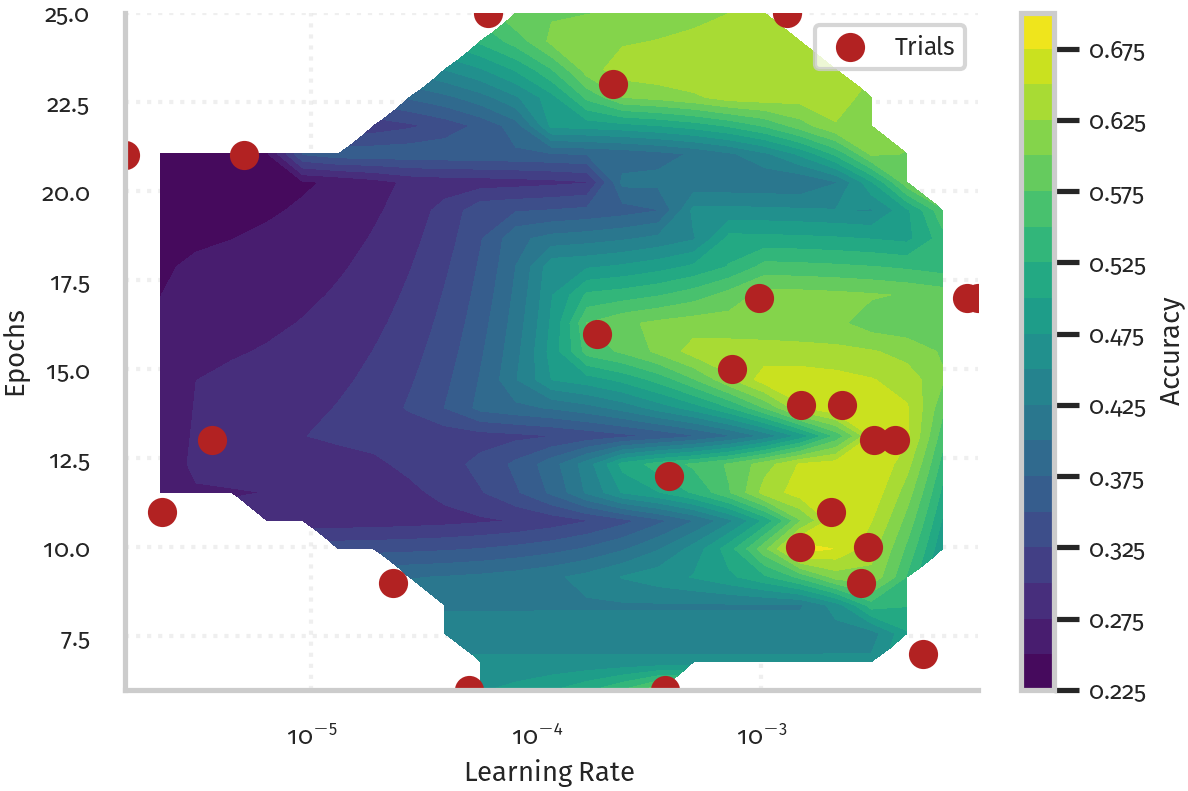

In [ ]:
from scipy.interpolate import griddata

def plot_contour_interp(df_scatter, filename, n_points=25):
    lr_vals = np.logspace(np.log10(df_scatter["lr"].min()),
                          np.log10(df_scatter["lr"].max()), n_points)
    epoch_vals = np.linspace(df_scatter["epochs"].min(),
                             df_scatter["epochs"].max(), n_points)
    
    X, Y = np.meshgrid(lr_vals, epoch_vals)
    
    # Interpolate z values on grid
    Z = griddata(
        points=df_scatter[["lr", "epochs"]].values,
        values=df_scatter["val_acc"].values,
        xi=(X, Y),
        method="linear"  # or 'linear'
    )
    
    plt.figure(figsize=(6,4), constrained_layout=True)
    cs = plt.contourf(X, Y, Z, levels=20, cmap="viridis")
    plt.xscale("log")
    plt.xlabel("Learning Rate")
    plt.ylabel("Epochs")
    plt.scatter(df_scatter["lr"], df_scatter["epochs"], color="firebrick", label="Trials")
    plt.colorbar(cs, label="Accuracy")
    plt.legend()
    plt.show()

plot_contour_interp(df_bayesian, "contour_bayesian_interp")